4.	Build supervised machine learning model(s) to predict annual net savings based on other variables. Include appropriate safeguards against overfitting. Comment on the results. How well do the models perform? Is the performance stable? Are the models interpretable / explainable? Are these models suitable for decision-making? Is there enough signal in the data to build good models? Is there anything suspicious about the results?

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# from pickle import dump

from sklearn.preprocessing import MinMaxScaler



from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, r2_score


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from pickle import dump


In [6]:
# read the cleaned dataset 
df = pd.read_pickle('data/customer_data_modified.pkl')

In [7]:

input_num_variables = ['net_salary', 'other_income', 'housing_spend', 'childcare_spend', 'gambling_spend', 'credit_score', 'savings_bal_lbg', 'observed_surplus', 'age']
input_cat_variables = ['gender_cat', 'ethnicity_group_cat', 'geo_region_cat']
all_input_variables = input_num_variables + input_cat_variables
target_var = 'annual_net_savings_lbg'

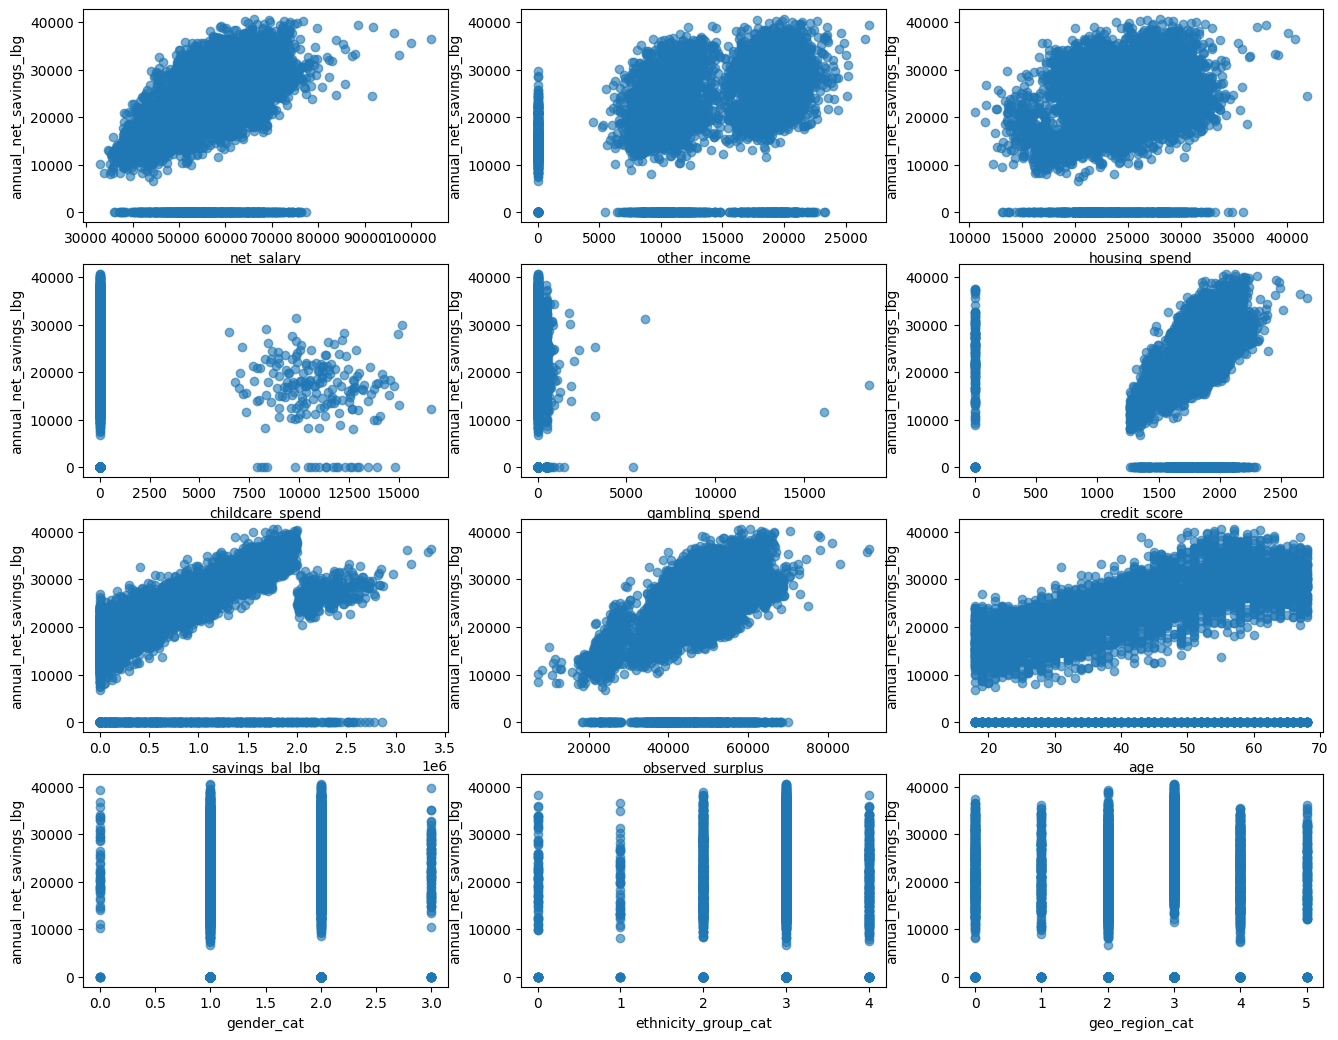

In [8]:
#check the variation of target variable with individual input variable
plt.figure(figsize=(16,16))
for i, var in enumerate(all_input_variables):
    plt.subplot(5,3,i+1)
    plt.scatter(df[var], df[target_var], alpha=0.6)
    plt.xlabel(var)
    plt.ylabel(target_var)

In [9]:
# predicting these net_savings = 0 values will be difficult 
# and model will not be stable 

df[df.annual_net_savings_lbg == 0.].cust_unique_id.count()

604

In [10]:
# drop these cases where annual net saving is zero

df = df[df.annual_net_savings_lbg !=0]

 Note: 
 
 * If its necessary to predict the cases where `annual_net_savings_lbg` is 0, a classifier should be trained to predict these cases. So essentially the problem is a classification + regression problem. Will move on with rgression for now.

 * Also as seen in correlation in part #2 and in the plots above both `childcare_spend` and `gambling_spend` has little correlation with annual net income. In fact, there is an imbalance between zero vs non-zero values - which will make the model unstable. Drop those varibles as input featues. Instead `observed_surplus` and `housing_spend` will capture the dependence.  

In [11]:
# update the input features 
input_num_variables = ['net_salary', 'other_income', 'housing_spend', 'credit_score', 'savings_bal_lbg', 'observed_surplus', 'age']
input_cat_variables = ['gender_cat', 'ethnicity_group_cat', 'geo_region_cat']
all_input_variables = input_num_variables + input_cat_variables

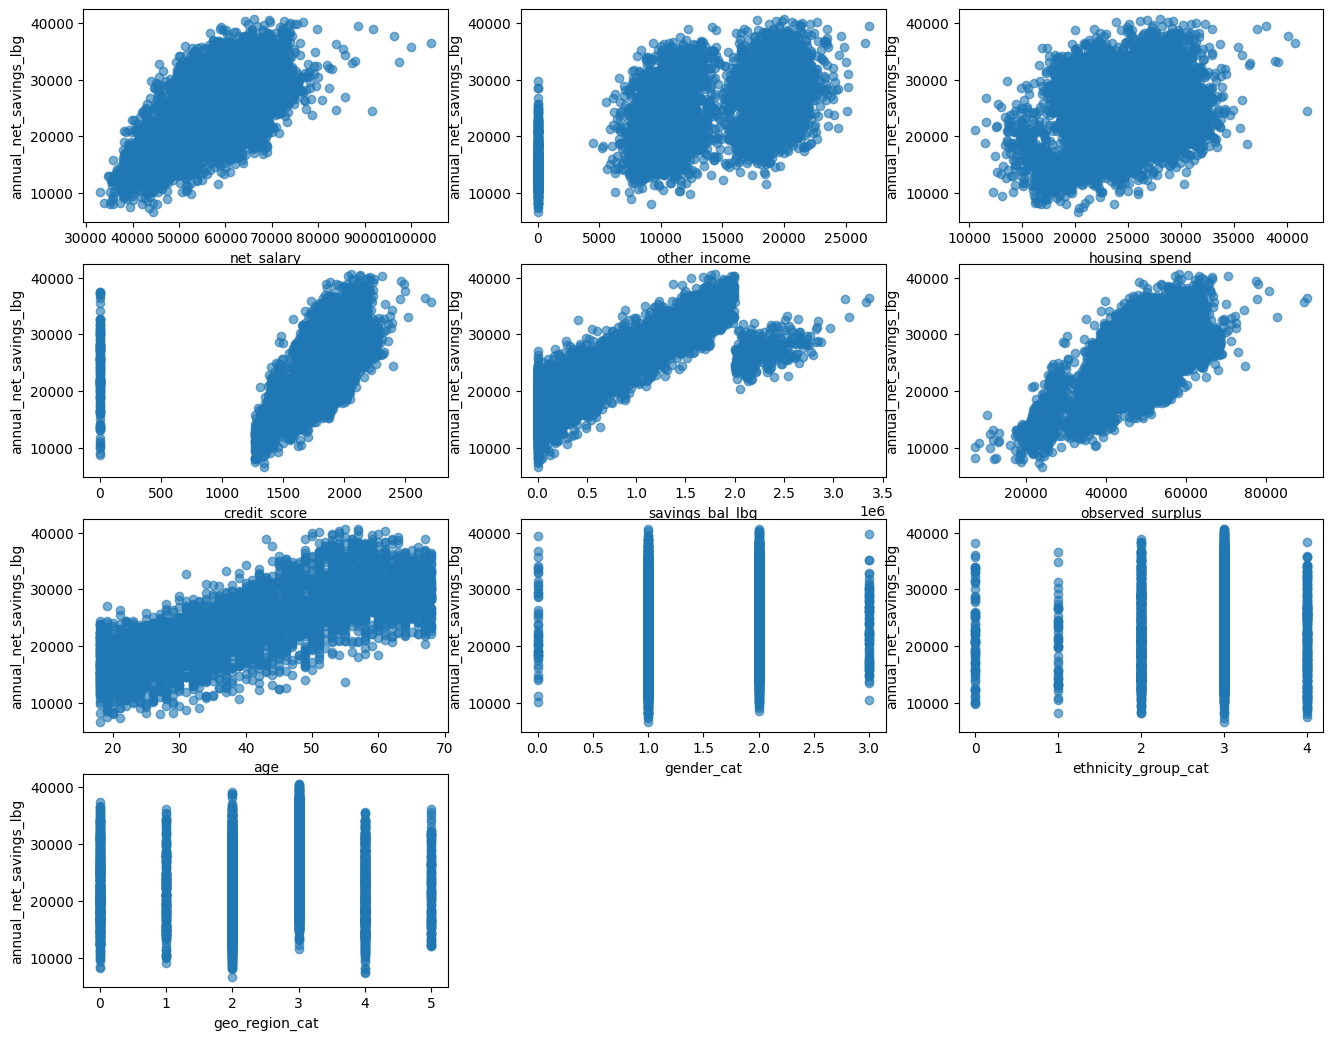

In [12]:
#check the variation of target variable with individual input variable
plt.figure(figsize=(16,16))
for i, var in enumerate(all_input_variables):
    plt.subplot(5,3,i+1)
    plt.scatter(df[var], df[target_var], alpha=0.6)
    plt.xlabel(var)
    plt.ylabel(target_var)

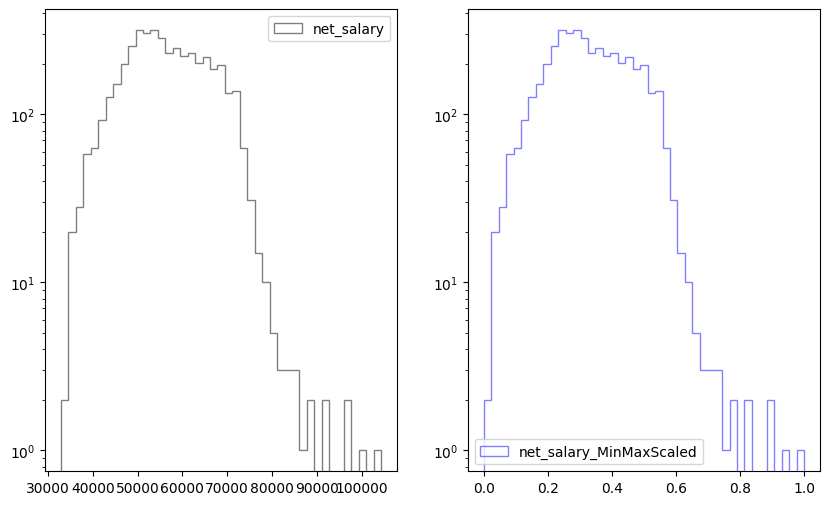

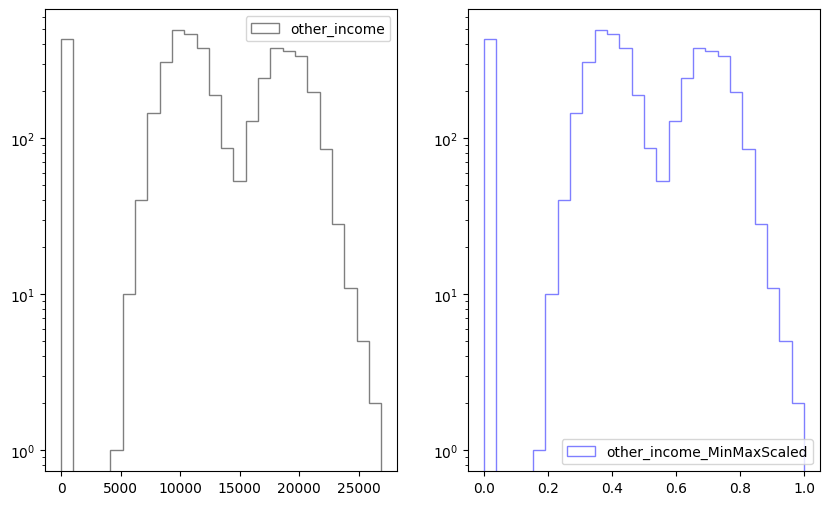

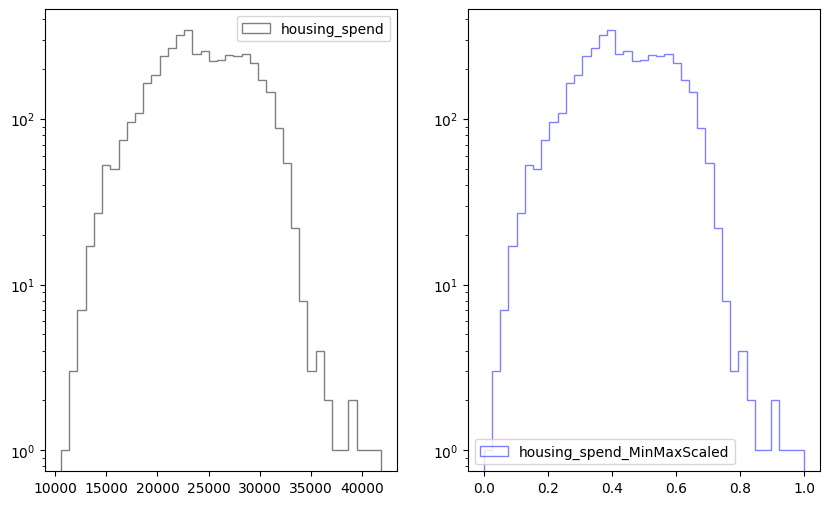

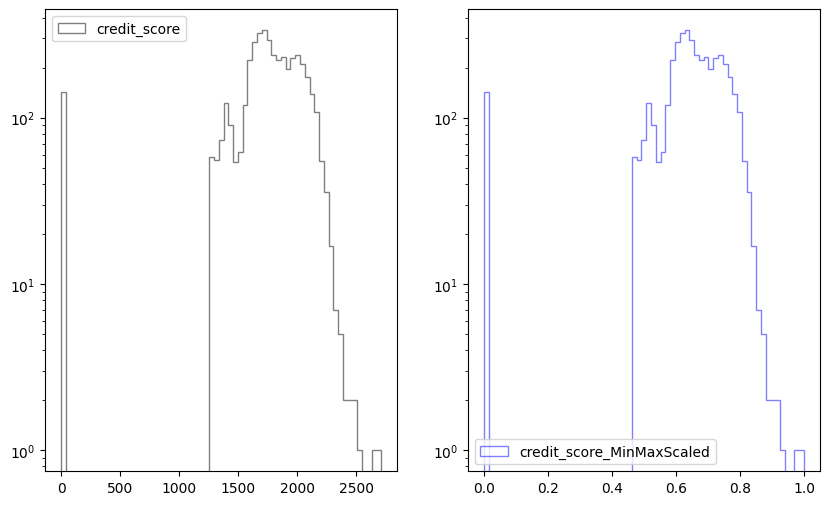

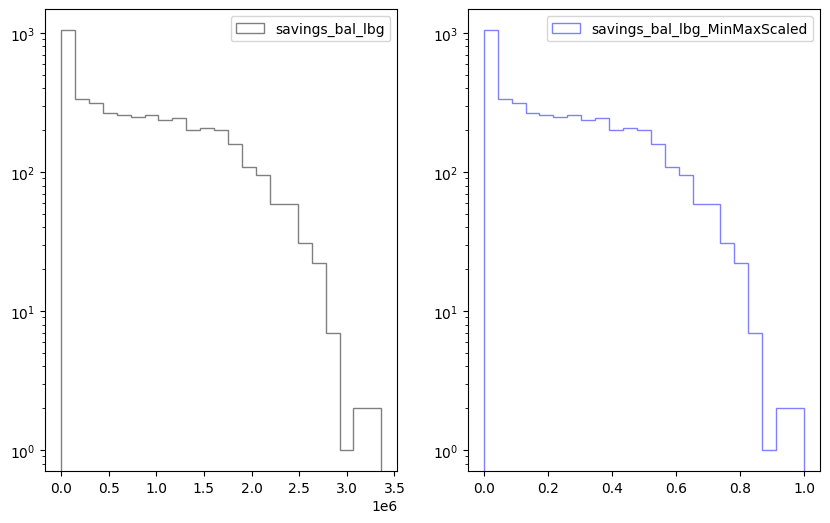

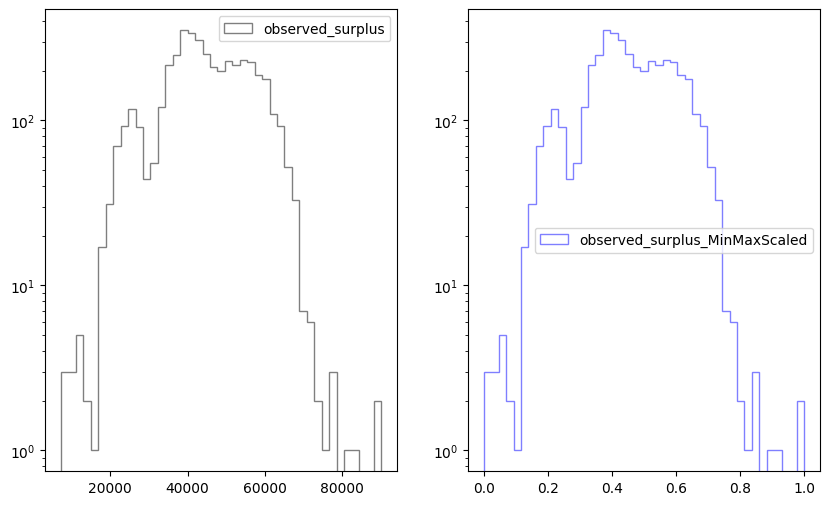

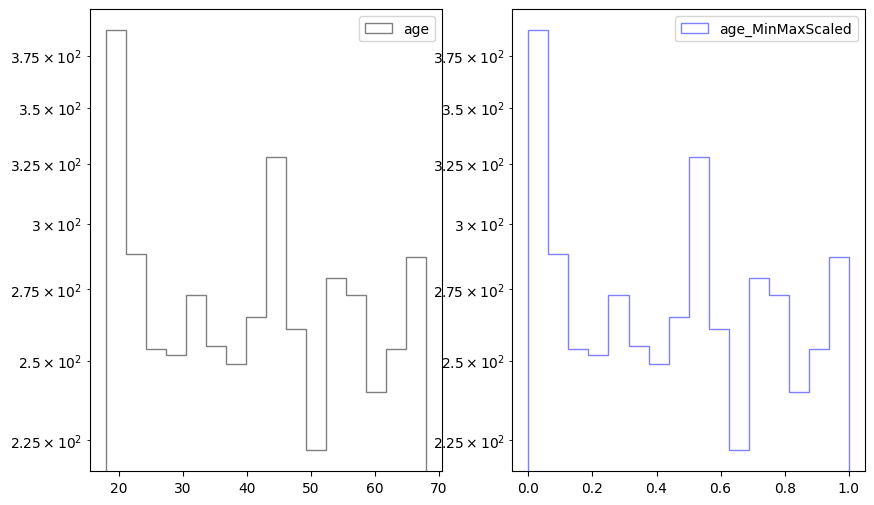

In [13]:
# since we have large scale in our numerical distribution, scaling the data with a MinMaxScalar will be suitable since it will preserve the shape of the distribution with values [0,1]
# lets check the transformed data to make sure
data_num_input = df[input_num_variables]
trans = MinMaxScaler().set_output(transform='pandas')
trans_data_num_input = trans.fit_transform(data_num_input)

for col in trans_data_num_input.columns:
    plt.figure(figsize=(10,6))
    plt.subplot(121)
    plt.hist(df[col], density=False, alpha=0.5, label=col,histtype='step', stacked=True, color='black', log=True, bins='auto')
    plt.legend()
    plt.subplot(122)
    plt.hist(trans_data_num_input[col], density=False, alpha=0.5, label=col+'_MinMaxScaled',histtype='step', stacked=True, color='blue', log=True, bins='auto')
    plt.legend()

Based on these distributions, `will choose MinMaxScaler`, however note that we will need to apply the same transformation to both train, test data - so will only derive the minmax scalar model by fitting only the training datasets

Now, lets start investigating some models. Will use k-fold cross validation with 10 folds to estimate model performance and to ensure there is no overfitting. 

In [14]:
# define k-fold cross-validaton 
cvkfold = KFold(n_splits=10, random_state=42, shuffle=True)

In [15]:
# create a pipeline that will transform numerical features using minmax scaler for each fold, categorical ones are already labelled  and will pass through the pipeline

def create_preprocessor_model_pipeline(numerical_features, model):
    numeric_transformer = Pipeline(steps=[('minmax', MinMaxScaler())])
    
    preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numerical_features)], remainder='passthrough')
    preprocessor_model = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

    return preprocessor_model


In [16]:
# function use the pipeline from above and train the model
# save all the information in each fold
def train_model(df, cv, preprocessor_model):
    train_datastets={}
    test_datasets={}
    models ={}
    predictions={}
    scores={}
    residuals={}
    mse={}


    for i, (train_index, test_index) in enumerate(cv.split(df)):
        fold = 'k_' + str(i)
        # print(i)
        # print(f'train_index {train_index}, shape: {train_index.shape}')
        # print(f'test_index: {test_index} shape: {test_index.shape}')
        # print(f'train data: {df.iloc[train_index]}, test data: {df.iloc[test_index]}')
        train_datastets[fold] = train_index
        test_datasets[fold] = test_index
        df_train = df.iloc[train_index]
        df_test = df.iloc[test_index]
        models[fold] = preprocessor_model.fit(df_train[all_input_variables], df_train[target_var])
        scores[fold] = preprocessor_model.score(df_test[all_input_variables], df_test[target_var])
        predictions[fold] = preprocessor_model.predict(df_test[all_input_variables])
        residuals[fold] = np.subtract(predictions[fold], df_test[target_var])
        mse[fold] = mean_squared_error(df_test[target_var], predictions[fold] )
       

    return train_datastets, test_datasets, models, predictions, scores, residuals, mse

In [42]:
# func to plot true v pred 
def plot_true_pred(y_test, y_pred, title='true vs pred'):
    f, ax = plt.subplots(figsize=(8,6))
    ax.scatter(y_test, y_pred)
    ax.plot(range(40000), range(40000))
    ax.set_xlabel("Actual annual net savings (GBP)")
    ax.set_ylabel("Predicted annual net savings (GBP)")
    ax.set_title(title)
    return ax 

## Models:

To begin with, will investigate a linear regression model and an ensemble model 

### Linear regression

In [18]:
lr = LinearRegression()
lr_pipeline = create_preprocessor_model_pipeline(input_num_variables, lr)
lr_train_datastets, lr_test_datasets, lr_models, lr_predictions, lr_scores, lr_residuals, lr_mse = train_model(df, cvkfold, lr_pipeline)


In [19]:
#R^2 scores
lr_scores

{'k_0': 0.7965707366180662,
 'k_1': 0.8069074909256292,
 'k_2': 0.7821874222352274,
 'k_3': 0.7659997323149392,
 'k_4': 0.8145302511178726,
 'k_5': 0.785109645076004,
 'k_6': 0.8045482089009007,
 'k_7': 0.8045999935476995,
 'k_8': 0.7716983285597402,
 'k_9': 0.7994925582654641}

In [20]:
# mean square error 
lr_mse

{'k_0': 8779931.304379817,
 'k_1': 8812016.002332916,
 'k_2': 9840113.825914023,
 'k_3': 9253667.092400024,
 'k_4': 7640841.16948569,
 'k_5': 9721056.927945849,
 'k_6': 7797340.48752216,
 'k_7': 8247556.886243936,
 'k_8': 9124939.053448528,
 'k_9': 8986038.272836357}

In [21]:
# coefficients
model_k0 = lr_models['k_0']['model']
model_k0.coef_

array([-2.71168732e+03,  1.18877601e+02,  1.23430617e+03,  3.20830252e+02,
       -1.25746271e+04,  3.02167939e+04,  2.05222876e+04,  1.96158406e+02,
       -1.70519027e+02, -2.89192118e+01])

437
437


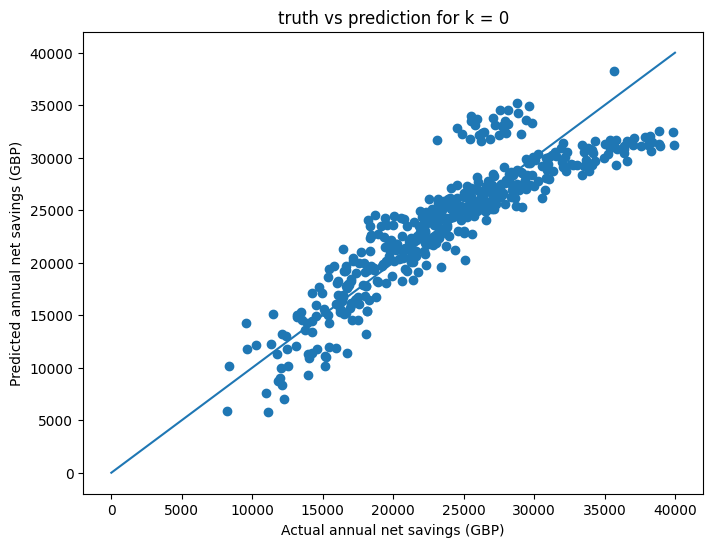

In [43]:
# plot the true vs prediction 

y_test = list(df.iloc[lr_test_datasets['k_0']][target_var])
print(len(y_test))
y_pred = list(lr_predictions['k_0'])
print(len(y_pred))
ax = plot_true_pred(y_test, y_pred, "truth vs prediction for k = 0")
plt.show()

Alreday the linear regression performs well, scores from each fold is consistent

## Random Forest Regressor 

In [32]:
rf = RandomForestRegressor(n_estimators=10, random_state=42, criterion='friedman_mse')
rf_pipeline = create_preprocessor_model_pipeline(input_num_variables, rf)
rf_train_datastets, rf_test_datasets, rf_models, rf_predictions, rf_scores, rf_residuals, rf_mse = train_model(df, cvkfold, rf_pipeline)


In [33]:
rf_scores

{'k_0': 0.9054354892523391,
 'k_1': 0.8961164601286704,
 'k_2': 0.9082220495651931,
 'k_3': 0.8853450689456772,
 'k_4': 0.8932221913417968,
 'k_5': 0.9142326395531211,
 'k_6': 0.908301337199371,
 'k_7': 0.9030564636583591,
 'k_8': 0.8806125836757286,
 'k_9': 0.910299572915663}

In [34]:
rf_mse

{'k_0': 4081369.093088327,
 'k_1': 4740854.112432524,
 'k_2': 4146250.360082082,
 'k_3': 4534091.23406108,
 'k_4': 4398950.671473545,
 'k_5': 3879882.807018711,
 'k_6': 3658220.229583162,
 'k_7': 4091849.0497927316,
 'k_8': 4771769.259660145,
 'k_9': 4020057.6292664493}

437
437


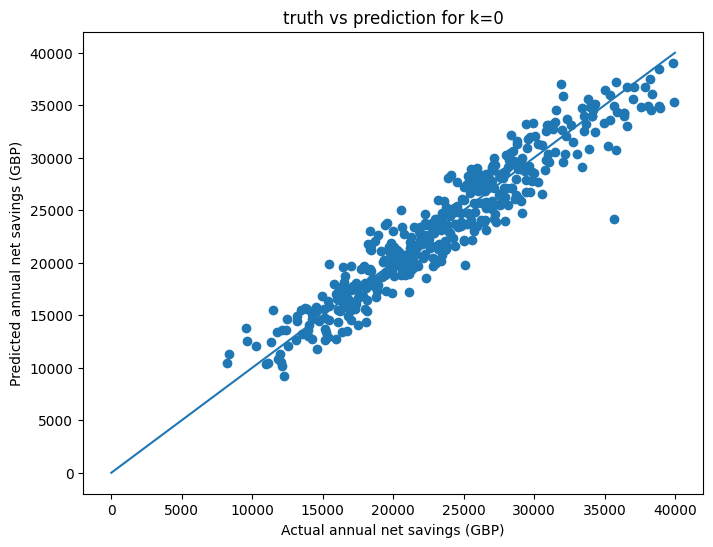

In [44]:
# plot the true vs prediction 

# for i in range(0,10):
i=0
fold = 'k_'+str(i)
y_test = list(df.iloc[rf_test_datasets[fold]][target_var])
print(len(y_test))
y_pred = list(rf_predictions[fold])
print(len(y_pred))
ax = plot_true_pred(y_test, y_pred, f'truth vs prediction for k={i}')
plt.show()

Performance this model is quite good. Will use this model for predictions

### Model of choice:

Mean squared error = 4418300.277082536
R^2 = 0.9005232382288568


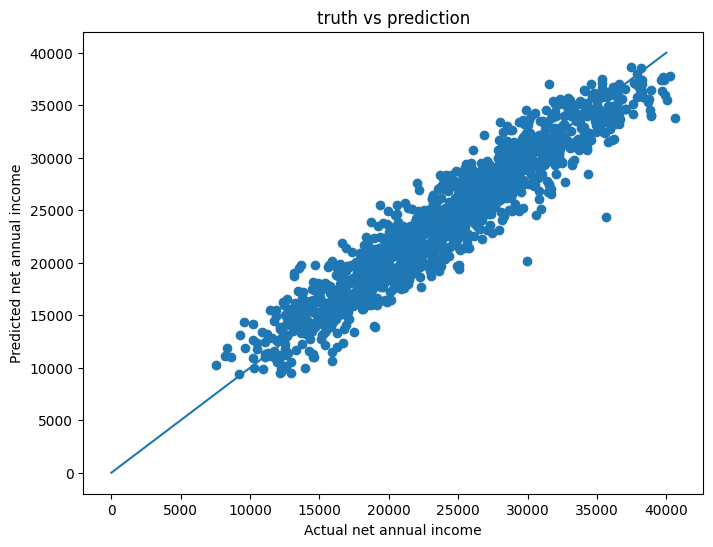

In [40]:
X = df[all_input_variables]
y = df[target_var]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

scale_minmax = MinMaxScaler().set_output(transform='pandas')
X_train_num = X_train[input_num_variables]
X_test_num = X_test[input_num_variables]
X_train_num_scaled = scale_minmax.fit_transform(X_train_num)
X_test_num_scaled = scale_minmax.transform(X_test_num)

df_train_scaled = pd.concat([X_train_num_scaled, X_train[input_cat_variables]], axis=1, join='inner')
df_test_scaled = pd.concat([X_test_num_scaled, X_test[input_cat_variables]], axis=1, join='inner')


model = RandomForestRegressor(n_estimators=10, random_state=42, criterion='friedman_mse')
model.fit(df_train_scaled, y_train)
y_pred = model.predict(df_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean squared error = {mse}')
print(f'R^2 = {r2}')

ax = plot_true_pred(y_test, y_pred, "truth vs prediction")
plt.show()

# save the model 
dump(model, open('models/net_salary_pred_non_ethical.pkl', 'wb'))

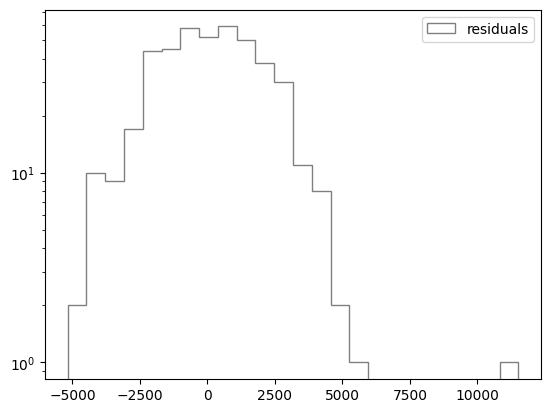

In [51]:
# plot the residuals 
residual = np.subtract(y_test, y_pred)
plt.figure()
plt.hist(residual, density=False, alpha=0.5, label='residuals',histtype='step', stacked=True, color='black', log=True, bins='auto')
plt.legend()

will be interesting to investigate the outlier. But will move one for now. 


5.	Are there any ethical concerns with using any of the predictor variables in the dataset? Which variables, and why? Would you change the model to address these concerns? Does this change have a cost in terms of model performance? How would you balance performance against ethics? Which model would you finally decide to use to predict customer savings rates, and why? Is there anything else ethically questionable about the data?
